This project uses deep learning to predict the categories of images in the Fashion MNIST dataset. 

The idea originated while I was still modeling. Most of my regular clients were ecommerce fashion retailers, and some of them had issues with products being mislabeled on their website.  Often items would end up in the wrong category: men’s items would appear under women’s, a shirt would end up in the dresses section, a pair of red pants would be labeled as blue. If a customer searches the site for red pants, they won’t find that pair! 

After all the hard work the creative team and I did around styling, modeling, photographing, and editing the images of these products, it was absolutely maddening when they didn’t end up in the right place on the company’s website. I asked around and discovered that humans were responsible for manually catching these errors - and with sometimes tens of thousands of new products being added to a site per day, it’s no wonder mistakes happened. 

I’d been really enjoying reading about fun projects using computer vision using convolutional neural networks, and this seemed like a practical business application of the technology. Could I train a neural net to classify the images better than a human? Or at least flag suspiciously labeled images, so a human could do a quick review of this smaller subset of images. I realize a deep learning project is a big undertaking as a first project, but I’m excited about solving a real world business problem, so here goes!

I found two fashion image datasets that are good approximations of the type of images ecommerce fashion retailers use. I’ll start with the Fashion MNIST.

## Data
Similar to the MNIST dataset, the Fashion MNIST dataset contains a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

### Labels:
Each training and test example is assigned to one of the following labels:

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot 


## Measuring success
Accuracy will be the measure of success: number of correctly predicted images / total number of images

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import classification_report

Using TensorFlow backend.
/Users/katrinasperry/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train_data = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

In [3]:
# check training data shape
train_data.shape

(60000, 785)

In [4]:
# check test data shape
test_data.shape

(10000, 785)

In [5]:
train_data.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9    ...     pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0        30        43   
3       0    ...            3         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0         0  
1         0         0         0         0         0  
2         0         0         0         0         0  
3         1         0         0         0         0  
4         0         0         0         0         0  

[5 rows x 785 columns]

### Prepare image data

In [6]:
# convnets take input tensors of shape (image_height, image_width, image_channels)
# we want these images to have size (28, 28, 1)
train_images = np.array(train_data.iloc[:,1:])
train_images = train_images.reshape((60000, 28,  28, 1))
train_images = train_images.astype('float32') / 255

test_images = np.array(test_data.iloc[:,1:])
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

### Prepare labels

In [7]:
train_labels = to_categorical(np.array(train_data.iloc[:,0]))
test_labels = to_categorical(np.array(test_data.iloc[:,0]))

In [8]:
# train, validation (to optimize classifier during training) split
# X (predictor) = images
# y (target) = labels
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=13)

In [9]:
# create dictionary with label numbers as keys, label names as values
label_names = { 0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot" }
print(label_names)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


### Visualize sample image and label

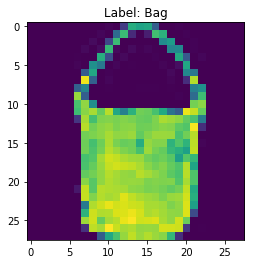

In [10]:
img = train_images[57]
plt.imshow(img.reshape(28,28), cmap='viridis', interpolation='none')
plt.title("Label: {}".format(label_names[train_data.iloc[57]['label']]))
plt.show()

## Instantiate a convolutional neural net

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
__________

### Fit model to training and validation data

In [15]:
history = model.fit(X_train, y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 47s 982us/step - loss: 0.8419 - acc: 0.6871 - val_loss: 0.5219 - val_acc: 0.8092
Epoch 2/50
48000/48000 [==============================] - 46s 966us/step - loss: 0.5249 - acc: 0.8059 - val_loss: 0.4313 - val_acc: 0.8464
Epoch 3/50
48000/48000 [==============================] - 45s 946us/step - loss: 0.4570 - acc: 0.8321 - val_loss: 0.3863 - val_acc: 0.8592
Epoch 4/50
48000/48000 [==============================] - 48s 995us/step - loss: 0.4147 - acc: 0.8478 - val_loss: 0.3458 - val_acc: 0.8750
Epoch 5/50
48000/48000 [==============================] - 46s 969us/step - loss: 0.3831 - acc: 0.8595 - val_loss: 0.3261 - val_acc: 0.8790
Epoch 6/50
48000/48000 [==============================] - 47s 986us/step - loss: 0.3607 - acc: 0.8681 - val_loss: 0.3204 - val_acc: 0.8817
Epoch 7/50
48000/48000 [==============================] - 48s 1ms/step - loss: 0.3431 - acc: 0.8726 - val_loss: 0.29

In [16]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20567868646383286
Test accuracy: 0.9251


# Results:

Woohoo! This classifier has better accuracy than the best baseline, which used an SVM classifier to achieve 0.91.

### Plot training and validation accuracy and loss

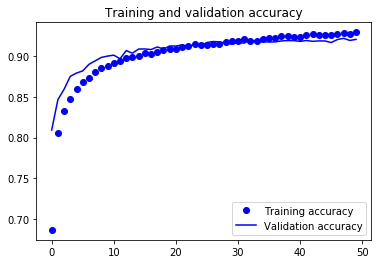

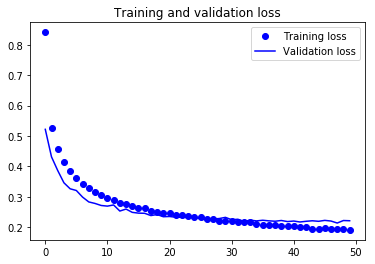

In [17]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# save model
model.save('cnn1.h5')

#### The network starts to overfit after about 35 epochs. Let's train a new network for just 35 epochs and see how it performs.

## Convolutional neural net take II

In [24]:
# same code as above
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [26]:
# change epochs to 35, keep the rest the same as above
history2 = model2.fit(X_train, y_train,
          batch_size=256,
          epochs=35,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/35
48000/48000 [==============================] - 49s 1ms/step - loss: 0.4333 - acc: 0.8411 - val_loss: 0.3612 - val_acc: 0.8668
Epoch 2/35
48000/48000 [==============================] - 45s 935us/step - loss: 0.3902 - acc: 0.8573 - val_loss: 0.3280 - val_acc: 0.8799
Epoch 3/35
48000/48000 [==============================] - 45s 944us/step - loss: 0.3618 - acc: 0.8679 - val_loss: 0.3334 - val_acc: 0.8742
Epoch 4/35
48000/48000 [==============================] - 45s 929us/step - loss: 0.3452 - acc: 0.8742 - val_loss: 0.2958 - val_acc: 0.8922
Epoch 5/35
48000/48000 [==============================] - 45s 933us/step - loss: 0.3272 - acc: 0.8804 - val_loss: 0.2895 - val_acc: 0.8953
Epoch 6/35
48000/48000 [==============================] - 45s 935us/step - loss: 0.3154 - acc: 0.8861 - val_loss: 0.2867 - val_acc: 0.8943
Epoch 7/35
48000/48000 [==============================] - 45s 936us/step - loss: 0.3078 - acc: 0.8875 - val_loss: 0.27

In [27]:
score2 = model2.evaluate(test_images, test_labels, verbose=0)
print('Test loss 2:', score[0])
print('Test accuracy 2:', score[1])

Test loss 2: 0.20567868646383286
Test accuracy 2: 0.9251


# Results:

Compared to the first convnet, this one has slightly higher test loss and slightly lower accuracy. The accuracy is on par with the exhisting SVM classifier baseline of 0.91.

### Plot training and validation accuracy and loss

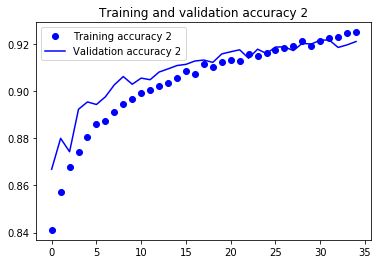

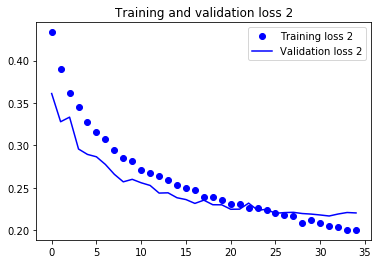

In [32]:
accuracy2 = history2.history['acc']
val_accuracy2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(len(accuracy2))

plt.plot(epochs2, accuracy2, 'bo', label='Training accuracy 2')
plt.plot(epochs2, val_accuracy2, 'b', label='Validation accuracy 2')
plt.title('Training and validation accuracy 2')
plt.legend()

plt.figure()

plt.plot(epochs2, loss2, 'bo', label='Training loss 2')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss 2')
plt.title('Training and validation loss 2')
plt.legend()

plt.show()

#### Hmm this time it looks like the network starts to overfit a bit earlier than before.

### Make predictions with test data

In [33]:
predicted_classes = model.predict_classes(test_images)

### Classification report

In [34]:
# get the indices to be plotted
y_true = test_data.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [35]:
target_names = ["{}".format(label_names[i]) for i in range(10)] # 10 being the number of classes
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

T-shirt/top       0.90      0.85      0.88      1000
    Trouser       0.99      0.98      0.99      1000
   Pullover       0.93      0.86      0.90      1000
      Dress       0.93      0.94      0.93      1000
       Coat       0.90      0.88      0.89      1000
     Sandal       0.99      0.97      0.98      1000
      Shirt       0.74      0.83      0.78      1000
    Sneaker       0.95      0.97      0.96      1000
        Bag       0.99      0.99      0.99      1000
 Ankle boot       0.97      0.97      0.97      1000

avg / total       0.93      0.93      0.93     10000



## Let's see what the neural net is really up to!
#### First, we'll look at examples of images it predicted correctly and incorrectly, and then we'll check out the activations of each layer to see what they're actually doing.

### Examples of correctly predicted images:

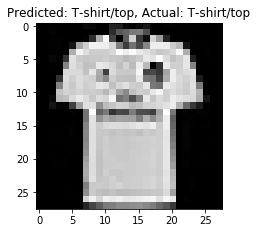

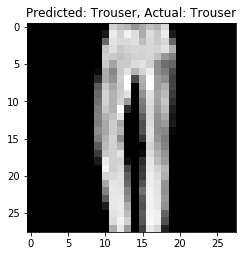

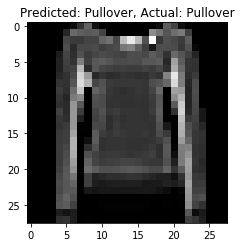

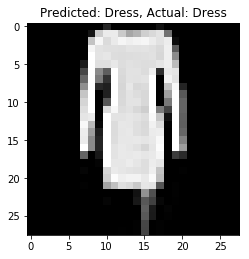

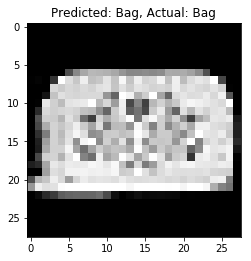

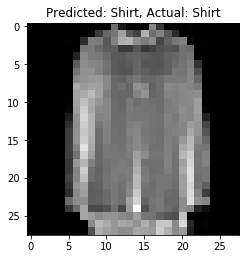

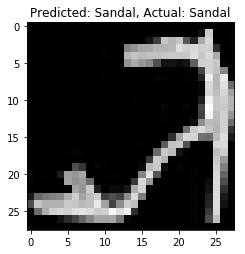

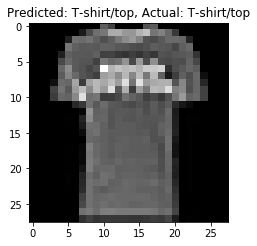

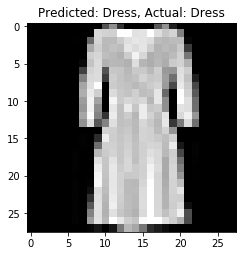

In [36]:
for i, correct_img in enumerate(correct[:9]):
    plt.figure(figsize=(10,10))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[correct_img].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Actual: {}".format(label_names[predicted_classes[correct_img]], label_names[y_true[correct_img]]))
    plt.tight_layout()

### Examples of incorrectly predicted images:

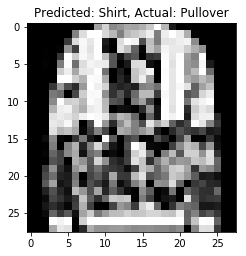

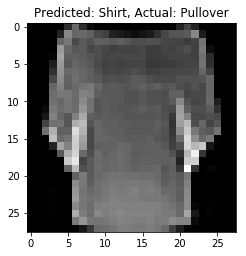

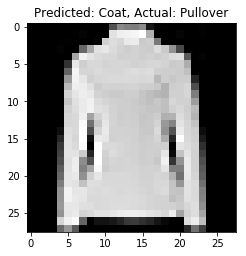

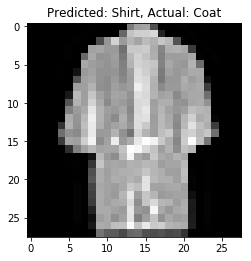

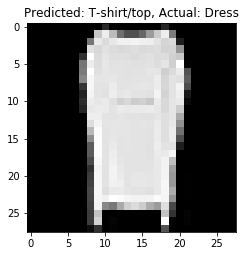

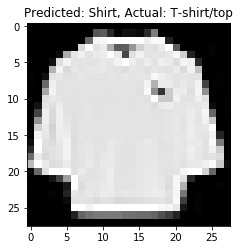

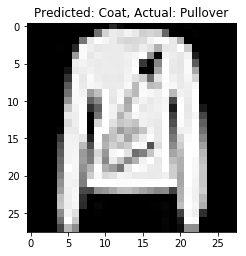

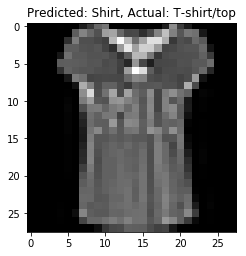

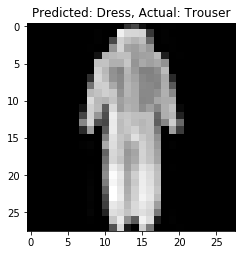

In [37]:
for i, incorrect_img in enumerate(incorrect[0:9]):
    plt.figure(figsize=(10,10))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[incorrect_img].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Actual: {}".format(label_names[predicted_classes[incorrect_img]], label_names[y_true[incorrect_img]]))
    plt.tight_layout()

### Visualizing intermediate activations

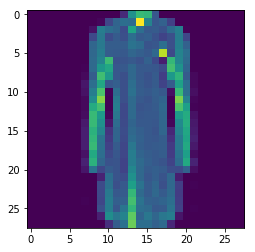

In [38]:
# visualize an image
img = train_images[33]
plt.imshow(img.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

#### Visualizing the 2nd channel of the first layer

/Users/katrinasperry/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


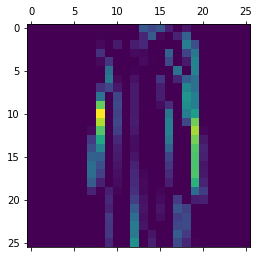

In [39]:
# instantiate a model from an input tensor and a list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)

# reshape img into 4 dimensional tensor
activations = activation_model.predict(img.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

#### Visualizing every channel in the intermediate activations

/Users/katrinasperry/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


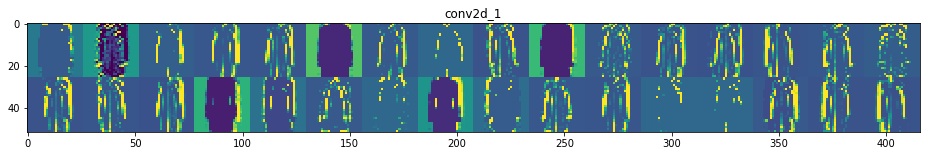

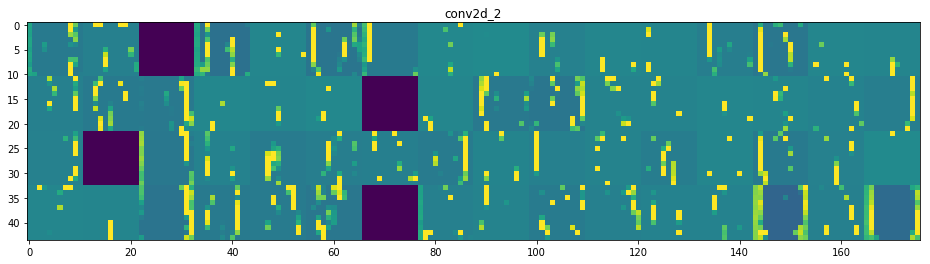

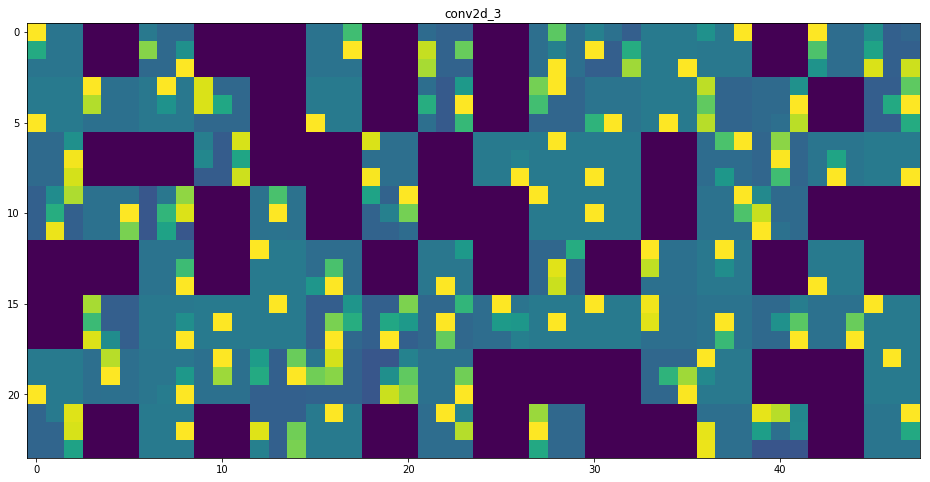

In [40]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Next steps

Run model with Deep Fashion dataset.